In [1]:
import os
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2 # opencv

In [2]:
num_classes = 100

data_dir = "/Users/aryamathew/Downloads/data/coil-100/"

images = []
classes = []
example_images = []
do_limit = False
max_per_class = 32
for i in range(num_classes):

    filenames = glob.glob(data_dir + 'obj' + str(i+1) + '_*.png')
    
    for j in range(len(filenames)):
        
        #print('reading ', filenames[j])
        im_gbr = cv2.imread(filenames[j])
        im = cv2.cvtColor(im_gbr,cv2.COLOR_BGR2RGB) # convert from BGR ordering to RGB
        
        images.append(im)
        classes.append(i+1)

        if (j==0):
            example_images.append(im) # keep the first example of each class
            
        # limit to 10 images per example
        if do_limit:
            if (j>=max_per_class):
                break
                
print('read ', len(images), ' images ')

read  7200  images 


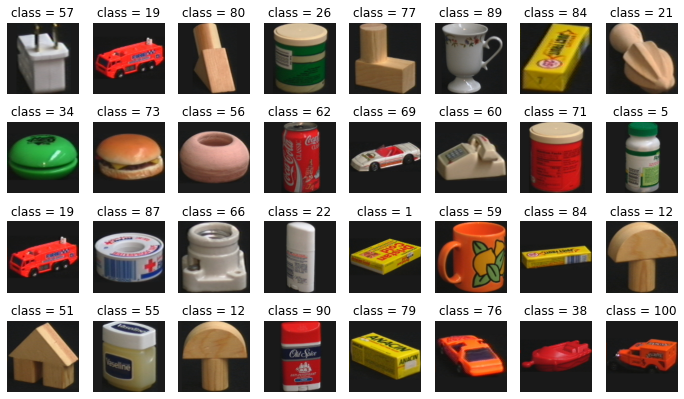

In [3]:
# plot some random images

fig = plt.figure(figsize=(12,7))
for i in range(32):

    r = np.random.randint(0,len(images))
    
    plt.subplot(4,8,i+1)
    plt.axis('off')
    plt.title('class = '+str(classes[r]))
    plt.imshow(images[r])
    
plt.show()

Bag of Words Features
A Bag of Words description is built in the following way:

1. Detect SIFT features on each of the input images
2. Cluster *all* SIFT features into a given number of clusters -- note the clustering 
is in the descriptor dimensions e.g. 128 for SIFT
3. Build a BoW descriptor for each image by binning detected features to the 
    nearest-neighbour cluster and counting numbers in each cluster
The BOW features are a histogram description of the original features in each image. Each image will then end up with a single histogram (BOW) with as many bins as clusters used in Step 2. above.

In theory, the clusters represent higher level local feature groupings which are discovered by the clustering of all the features over all the images.

### OpenCV Bag-of-Words creator
OpenCV contains a mechanism for creating BOW descriptors by 'training' a BOW method.

The dictionarySize argument is the number of clusters (or bins) in the output BOW we want (normally this is set to be smaller than the input feature dimensionality).

We feed use the add() function to add new feature descriptors extracted from each input image.

In [4]:
## Training BOW method

# extractor
# try lower contrastThreshold to get some descriptors for each image
sift = cv2.SIFT_create(contrastThreshold=0.02,sigma=1.35) # sift engine

descriptors_unclustered = []

dictionarySize = 32 # num words in BoW

bow_trainer = cv2.BOWKMeansTrainer(dictionarySize)

print('Dictionary size is ', dictionarySize)
print('Finding sift features over all the images...')


# keypoints: kps
# descriptors: desc
# Detecting features and extracting descriptors in all images
kps = []
for i in range(len(images)): # over all the images
    
    image = images[i]
    
    # calculate SIFT features on gray-scale version of it
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kp, desc = sift.detectAndCompute(gray, None)
    
    assert len(kp)>0
    
    kps.append(len(kp)) # so we can do a histogram of kps
    
    # add to the BoW 
    bow_trainer.add(desc)
    
print('Clustering dictionary....this might be slow....')
#dictionary created
dictionary = bow_trainer.cluster()   

print('...done')

Dictionary size is  32
Finding sift features over all the images...
Clustering dictionary....this might be slow....
...done


## OpenCV Bag-of-Words extractor

Once we have a dictionary, we need to use the OpenCV `BOWImgDescriptorExtractor` to 
find the nearest neighbour bins for a given new image. 

Note we can do it for any new image not just the ones used to train the BOW dictionary.

After this process is finished, each input image will have a new BOW feature associated with it.

In [8]:
# this will help extracts features from a BoW dictionary by using 
# NN to a given image and key points

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
sift2 = cv2.SIFT_create()

bow_extractor = cv2.BOWImgDescriptorExtractor(sift2, cv2.BFMatcher(cv2.NORM_L2))
bow_extractor.setVocabulary(dictionary)

print('bow dictionary', np.shape(dictionary))


# returns descriptor of image at pth
def feature_extract(bow_extractor, sift, image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return bow_extractor.compute(gray, sift.detect(gray))

features = [] # bow features for each image

print('doing bow feature extraction...')
for i in range(len(images)):
    
    bow_feats = feature_extract(bow_extractor, sift, images[i])
    
    features.append(bow_feats)
    
print('...done')

bow dictionary (32, 128)
doing bow feature extraction...
...done


## Multi-Layer Perceptrons using Keras

In the following, we will build a Multi-Layer Perceptron (MLP).

The MLP will be designed to input BOW features and output a label class (between 0-99).
So the input dimensionality will be `dictonarySize` and the output dimensionality will
be 100.

Here are the main steps of the method:
    
    1. Declare which Keras libraries we need: which ANN layers, optimizer etc.
    2. Wrangle the data into appropriate normalised input and output arrays {X, y} pairs
    3. Split the data into a training and a validation set
    4. Specify the ANN architecture (build the network and compile it)
    5. Train the network
    
Then we will do as above, which is to evaluate how good the predictor is.

In [5]:
# make some library declarations
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop

### Wrangle the data

We need to make sure that the input range is [0, 1] (which it is for BOW features).

The labels `y` need to be in the range [0,99] so we subtract 1 from `classes`.

We can use the `sklearn.utils.shuffle` to randomize the order of the data and the
corresponding lables.

Finally, we can split the data into a `train` and a `validate` set. We need to do this
for both the `x` and `y` vectors.

In [9]:
num_data = len(images)

x = np.array(features).reshape(num_data, dictionarySize) 
y = np.array(classes)-1 # range needs to be [0,99]

num_classes = np.max(y)+1

print('x shape is ', x.shape)
print('y shape is ', y.shape)
print('num classes is ', num_classes)

# shuffle the data
from sklearn.utils import shuffle
x, y = shuffle(x, y)

# the data, shuffled and split between train and test sets
# do a 70:30 split
num_train = int(70 * num_data/100)
num_validate = num_data - num_train

(x_train, y_train), (x_validate, y_validate) = (x[:num_train,:], y[:num_train]), \
                                       (x[num_train:,:], y[num_train:])

x_train = (x_train - np.min(x))/(np.max(x)-np.min(x)) # normalise the training data
x_validate = (x_validate - np.min(x))/(np.max(x)-np.min(x)) # normalise the validation data

print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'test samples')

x shape is  (7200, 32)
y shape is  (7200,)
num classes is  100
5040 train samples
2160 test samples


### One-Hot-Coding

The ANN will produce a vector probabilities (of length 100), where a 1.0 in 
position `c` indicates that class `c` has been predicted.

To train the network, we need to use *one-hot-coding* of our labels `y` before
we can use them to train the network.  This is done by 
```
    y_one_hot = keras.utils.to_categorical(y, num_classes)
    
```

In [10]:
# convert class vectors to binary class matrices
y_train_ohc = keras.utils.to_categorical(y_train, num_classes)
y_validate_ohc = keras.utils.to_categorical(y_validate, num_classes)
print('Num clases is ', num_classes)

print('Example of one-hot-coding: ')
print(y_train_ohc[0])
print(' is class ', y[0])

Num clases is  100
Example of one-hot-coding: 
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
 is class  8


### Exercise 
1. Build a MLP with 1 hidden layer (start with 32 neurons)

2. Train your network

3. If the network is overfitting, you may want to some things:

- change the number of neurons in the hidden layer
- try a Dropout layer after the hidden layer, e.g. with a dropout rate of 25%
 mode.add(Dropout(0.25))
- change the batch size
- try a smaller learning rate in the optimizer (change the lr value)
4. If it is not overfitting, can you get it to be more accurate by increasing the number of epochs?

5. Can you get more accuracy by adding a second hidden layer? Does it start to overfit or still work as well?

In [20]:
# make a simple nn

input_shape=32

model = Sequential()
# model.add(Dense(32,input_dim=32,init='uniform',activation='relu'))
model.add(Dense(32,input_dim=input_shape,activation='linear'))
# model.add(Dense(1,init='uniform',activation='linear'))
model.add(Dense(100,activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 100)               3300      
                                                                 
Total params: 4,356
Trainable params: 4,356
Non-trainable params: 0
_________________________________________________________________


### Training and fitting
This is how we would compile and fit the model

Note that each time we call compile() the weights get re-initialised.

In [21]:
# compile and train it!
epochs = 500 # 100, 300, 500 you choose
batch_size = 32 # 32, 64, 128 you choose

model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.fit(X,y,nb_epoch = 1000, batch_size = 4)
history=model.fit(x_train,y_train_ohc,epochs = epochs, batch_size = batch_size)

Epoch 1/500
158/158 [==============================] - 0s 453us/step - loss: 4.5867 - accuracy: 0.0341
Epoch 2/500
158/158 [==============================] - 0s 417us/step - loss: 4.5099 - accuracy: 0.1046
Epoch 3/500
158/158 [==============================] - 0s 416us/step - loss: 4.3550 - accuracy: 0.1274
Epoch 4/500
158/158 [==============================] - 0s 417us/step - loss: 4.1210 - accuracy: 0.1653
Epoch 5/500
158/158 [==============================] - 0s 412us/step - loss: 3.8746 - accuracy: 0.2165
Epoch 6/500
158/158 [==============================] - 0s 411us/step - loss: 3.6574 - accuracy: 0.2579
Epoch 7/500
158/158 [==============================] - 0s 411us/step - loss: 3.4695 - accuracy: 0.3002
Epoch 8/500
158/158 [==============================] - 0s 411us/step - loss: 3.3042 - accuracy: 0.3343
Epoch 9/500
158/158 [==============================] - 0s 410us/step - loss: 3.1584 - accuracy: 0.3673
Epoch 10/500
158/158 [==============================] - 0s 410us/step - l

## Plotting Training and Validation Accuracy

The `history` return from `fit()` will store the statistics from each epoch and we can
plot these to see whether the validation loss is lower than the training loss (which we want), 
or whether the model is starting to over fit.

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


dict_keys(['loss', 'accuracy'])


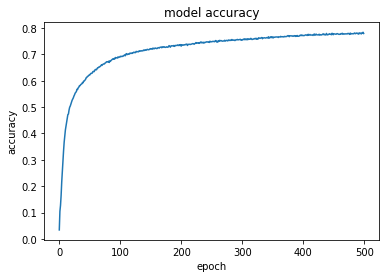

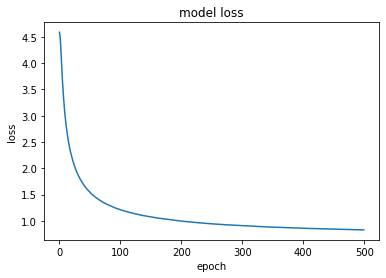

In [26]:
# this plots the change of accuracy and loss over time (stored in the 'history')

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Evaluating the trained model

We can see from the validation accuracy on the last epoch how good the model will be.

The `evaluate()` function can give us a score (the loss and the accuracy) like this...

In [27]:
score = model.evaluate(x_validate, y_validate_ohc, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7672151327133179
Test accuracy: 0.6083333492279053
